# FifaSkill

A Probabalistic Programming Package for European Soccer Analysis by Vinay Ramesh (vrr2112) and Alek Anchowski (aja2173)


In [1]:
from fifaskill.data_processing import process
from fifaskill.models import regression
import numpy as np
import pandas as pd
import sqlite3

from IPython.display import display

## Introduction

Trueskill, developed by Microsoft Research, is a Bayesian Skill Ranking System that models individual and team skill as Gaussians (Herbrich, Minka, Graepel). The original system models a player's skill, variance in performance, and uses an Expectation Propogation algorithm for inference. This paper was the central motivation to our project.

In our project Fifaskill, we attempt to extend the Trueskill method to FIFA games, with the aim of modeling a team's overall skill and predicting future matches. Some of the notable changes we adopt include:
 * Modeling: We not only model skill but also specific scoring outcomes to model domain specific features like offense and defense
 * Inference: We use Black Box Methods for Variational Inference or MAP Estimation instead of exact updates for Expectation Propagation [which is proved extremely difficult in Edward]
 * Criticism: We evaluate our model using mean statistic PPC to determine of goals predicted or goal difference predicted are reasonable

Our package can be installed by running `pip install .` after navigating to the first Fifaskill directory.

## Data

Our report begins in the middle of Box's loop to better understand the dataset used. We use the [Kaggle Dataset for European Soccer Matches](https://www.kaggle.com/hugomathien/soccer) 
consisting of lists of matches in 11 leagues for 8 seasons. Only intra-league games are provided and matches in joint European Leagues like the UEFA Champions League are not included. We are thus forced to evaluate leagues individually. The query we will use focuses on the English Premier League (EPL) but can be trivially modified to any other league by specifying the relevant country in the query file.  

A [Kaggle Notebook by Ashirwad](https://www.kaggle.com/ashirwadsangwan/competitiveness-in-the-european-leagues/notebook) noted that the parity was highest in the English Premier League within the given dataset which makes this particular league the most challenging and perhaps most interesting for our analysis. We draw the below image from his notebook analysis to demonstrate this fact.  

![alt text](https://github.com/vinoo999/trueskill_augmented/raw/master/final_project/images/competitiveness.png)


In [33]:
# Now we load our EPL Data
db = '../database.sqlite'
query_fname = '../db_queries/detailed_match_query.sql'

conn = sqlite3.connect(db)

q_file = open(query_fname, 'r')
data = pd.read_sql(q_file.read(), conn)

data.head(2)

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,1730,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Arsenal,West Bromwich Albion,1,0
1,1731,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Sunderland,Liverpool,0,1


Below we partition our data to get ready for training with our models.

In [34]:
train, test = process.partition_data(data, by_season=True)

display(train.head(2))
display(test.head(2))

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,1730,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Arsenal,West Bromwich Albion,1,0
258,1917,England,England Premier League,2008/2009,26,2009-02-23 00:00:00,Hull City,Tottenham Hotspur,1,2


,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
2912,4573,England,England Premier League,2015/2016,26,2016-02-13 00:00:00,Crystal Palace,Watford,1,2
2913,4574,England,England Premier League,2015/2016,26,2016-02-13 00:00:00,Everton,West Bromwich Albion,0,1


## Model

### The Original Model

The TrueSkill model described earlier models player performance $s$ as a Gaussian Random Variable with mean $\mu=25$ and $\sigma=\frac{25}{3}$. $\mu$ represents the player's "true" skill. It follows that, given two team's performances, $s_1$ and $s_2$, we can deterministically model the game's outcome, $r$ as below:
$$ r = \begin{cases} 1 & \text{ if } s_1 - s_2 > t \\-1 & \text{ if } s_1 - s_2 < -t \\ 0 & \text{ otherwise} \\\end{cases}$$
where $t$ is a threshold to determine draws. Probabalistically, we can thus draw $s \sim \mathcal{N}(\mu, \sigma)$ which is sufficient specify our generative 'outcomes.'

Originally, our intention was to use model data as follows:
 * Let there be $N$ teams and $M$ matches. Define the $N \times N$ matrix $R$[team1, team2] to be the average difference of goals scored between team1 and team2 in relevant matchups. Thus $R[team1, team2] == -R[team2, team1]$.
 * Our latent variable $S$ would then be a $N$-dimensional Normal vector whose pairwise distance draws would approximate $R$

After difficulty implementing this particular model in Edward we noticed that it could be translated into a simple Bayesian Linear Regression model:
 * Let $X$ be the $M \times N$ matrix where each row represents a two-hot vector where an entry is 1 if the team is home, -1 if the team is away, 0 otherwise
 * Define weight matrix $W \sim \mathcal{N}(25, \frac{25}{3} ^ 2)$ as a $d \times 1$ matrix denoting the skill of each team
 * $Y \sim \mathcal{N}(XW,\textbf{1})$ where $Y$ is the goal difference for a particular match

The graphical model is shown below.

![alt text](https://github.com/vinoo999/trueskill_augmented/raw/master/final_project/images/Bayesian_Linear_Regression.png)

In [4]:
inf_type = 'Var'

In [5]:
from fifaskill.models import regression
tsr = regression.TrueSkillRegressor(train, inf_type, n_iter=10000)

    1/10000 [  0%]                                ETA: 1726s | Loss: 8326.283

/mnt/c/Users/aanic/Documents/python-environments/pp/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 16s | Loss: 6247.814


### Offense Defense Separation

To extend the basic model we seperate the team's skill into two skills, offense $\mu_{io}$ and defense $\mu_{id}$. Offensive performance $W_o$ and defensive performance $W_d$ are modeled as Gaussian Random Variables. Offensive score $Y_1$ and defensive score $Y_2$ are modeled as Poisson Random Variables with rate parameter $W_o$ and $W_d$ respectively. We stick with our Bayesian Regression approach by having one $W_o$ vector and one $W_i$ vector. This is almost the composition of two log-linear models which can theoretically be written as a compound Poisson regression model. We look at both models [graphical models provided below] as our primary solutions to our Bayesian Skill problem. 

![alt text](https://github.com/vinoo999/trueskill_augmented/raw/master/final_project/images/Bayesian_Log_Linear_Model.png)
![alt text](https://github.com/vinoo999/trueskill_augmented/blob/master/final_project/images/Bayesian_Compound_Log_Linear2.png?raw=true)

In [6]:
off_def = regression.LogLinearOffDef(train, inf_type, n_iter=10000)
log_lin = regression.LogLinear(train, inf_type, n_iter=10000)

10000/10000 [100%] ██████████████████████████████ Elapsed: 21s | Loss: 9081.604
10000/10000 [100%] ██████████████████████████████ Elapsed: 19s | Loss: 76561.477


## Inference

In the definitions of the models above, our classes inadvertently run inference. Both MAP Estimation and Reparameterization Gradient Black Box Variational Inference were tested and can be tested using first code cell in the model section [`inf` can be set to `Var` or `MAP`]. There were no significant discoveries in differences in convergence time nor model evaluation statistics. Hamilton Monte Carlo was implemented in early stages of our model development, but we found more flexibility through Edward in using BBVI and MAP. 

Below we show the characteristic loss under Variational Inference. Note that the noise in the loss and resultingly the graident is very high. We were unable to reduce the variance substantially by reducing the learning rate or changing hyperparameters or optimizers for this particular inference problem. For the Offense-Defense model, which clearly has the most variance, RMSProp appeared to lower the variance for MAP Estimation but not for Variational Inference. 

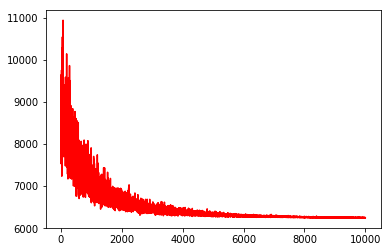

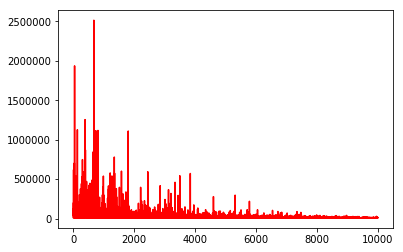

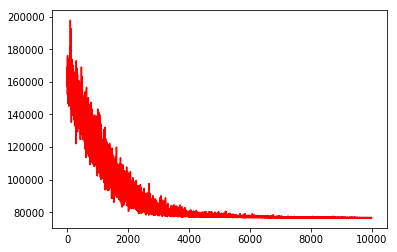

In [7]:
from fifaskill.data_processing import visualization
%matplotlib inline
visualization.plot_loss(tsr)
visualization.plot_loss(off_def)
visualization.plot_loss(log_lin)

### A TrueSkill Package as a Benchmark
This last model uses a TrueSkill python package that used expectation propagation as cited in the paper. We wrapped it to better serve our project. 

In [8]:
from fifaskill.models import trueskill_model
tsm = trueskill_model.TrueskillModel(train)

## Model Evaluation and Criticism

We will conduct both empirical evaluation as well as some pointwise statistic evaluation and lastly a posterior predictive check on the mean of the distribution. 

Firstly we provide the top ten skill-ordered rankings of the models

In [35]:
tsr_results = process.rankings_from_skills(tsr.team_skill, tsr.team_num_map)
offdef_results = process.rankings_from_skills(off_def.team_skill[0] + off_def.team_skill[1], off_def.team_num_map)
loglin_results = process.rankings_from_skills(log_lin.team_skill, log_lin.team_num_map)
tsm_results = process.rankings_from_skills(tsm.team_skills, tsm.team_num_map)

season_results = process.rankings(test)
data_dict = {}
data_dict['real_data'] = pd.Series(season_results.index.values)
data_dict['tsr'] = pd.Series(tsr_results.index.values)
data_dict['offdef'] = pd.Series(offdef_results.index.values)
data_dict['loglin'] = pd.Series(loglin_results.index.values)
data_dict['tsm'] = pd.Series(tsm_results.index.values)

display(pd.DataFrame(data_dict).head(10))

,real_data,tsr,offdef,loglin,tsm
0,Leicester City,Chelsea,Manchester United,Chelsea,Chelsea
1,Arsenal,Manchester United,Chelsea,Southampton,Manchester City
2,Tottenham Hotspur,Manchester City,Manchester City,Manchester City,Manchester United
3,Manchester City,Arsenal,Arsenal,Tottenham Hotspur,Arsenal
4,Manchester United,Liverpool,Liverpool,Manchester United,Tottenham Hotspur
5,Southampton,Tottenham Hotspur,Tottenham Hotspur,Liverpool,Liverpool
6,West Ham United,Everton,Everton,Arsenal,Everton
7,Liverpool,Southampton,Southampton,Leicester City,Southampton
8,Stoke City,Swansea City,Swansea City,Everton,Swansea City
9,Chelsea,Leicester City,Leicester City,Crystal Palace,Stoke City


As a clearer representation of similarity we can run simulations using our inferred parameters and display updated point tables. 

In [41]:
tsr_results = tsr.simulate(test.reset_index(drop=True))
tsr_record = process.gen_records(test.reset_index(drop=True), tsr_results)
offdef_results = off_def.simulate(test.reset_index(drop=True), num_simulations=10)
offdef_record = process.gen_records(test.reset_index(drop=True), offdef_results)
loglin_results = log_lin.simulate(test.reset_index(drop=True), num_simulations=10)
loglin_record = process.gen_records(test.reset_index(drop=True), loglin_results)
season_record = process.rankings(test.reset_index(drop=True))
tsm_results = tsm.simulate(test.reset_index(drop=True), num_simulations=10)
tsm_record = process.gen_records(test.reset_index(drop=True), tsm_results)


data_dict = {}
data_dict['real_data_points'] = pd.Series(season_record['points'], index=season_record.index.values)
data_dict['tsr_points'] = pd.Series(tsr_record['points'], index=tsr_record.index.values)
data_dict['offdef_points'] = pd.Series(offdef_record['points'], index=offdef_record.index.values)
data_dict['loglin_points'] = pd.Series(loglin_record['points'], index=loglin_record.index.values)
data_dict['tsm_points'] = pd.Series(tsm_record['points'], index=tsm_record.index.values)

record_chart = pd.DataFrame(data_dict)
record_chart = record_chart.sort_values(by='real_data_points', ascending=False)
display(record_chart.head(5))



,real_data_points,tsr_points,offdef_points,loglin_points,tsm_points
Leicester City,81.0,51.0,58.0,61.0,21.0
Arsenal,71.0,76.0,74.0,71.0,90.0
Tottenham Hotspur,70.0,54.0,69.0,93.0,70.0
Manchester United,66.0,63.0,92.0,93.0,90.0
Manchester City,66.0,62.0,69.0,94.0,90.0


Lastly we look at the Posterior Predictive Checks to check resemblance to the underlying distribution of goals. We see that the models do not seem to represent the true distribution well.

<Figure size 432x288 with 0 Axes>

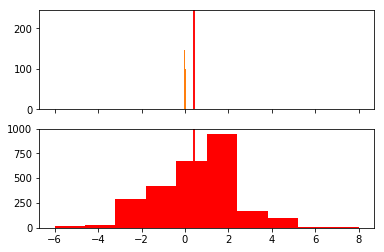

<Figure size 432x288 with 0 Axes>

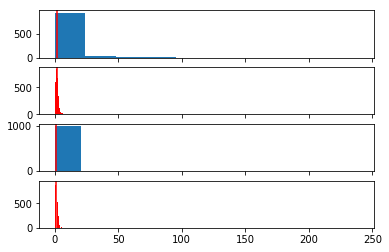

<Figure size 432x288 with 0 Axes>

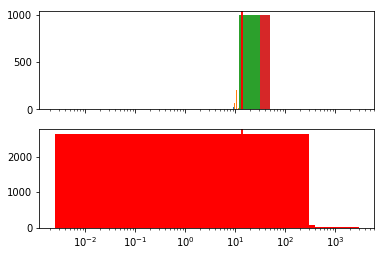

In [42]:
from matplotlib import pyplot as plt
%matplotlib inline
visualization.plot_ppcs(tsr)
visualization.plot_ppcs(off_def, log_plot=False)
visualization.plot_ppcs(log_lin, log_plot=True)

Here we evaluate accuracy

In [12]:
accuracies = np.zeros(4)
accuracies[0] = process.accuracy(test.reset_index(drop=True), tsr_results)
accuracies[1] = process.accuracy(test.reset_index(drop=True), loglin_results)
accuracies[2] = process.accuracy(test.reset_index(drop=True), offdef_results)
accuracies[3] = process.accuracy(test.reset_index(drop=True), tsm_results)

data_dict = {"accuracy": pd.Series(accuracies, index=['tsr', 'loglin', 'offdef', 'tsm'])}
display(pd.DataFrame(data_dict))

,accuracy
tsr,0.350000
loglin,0.442105
offdef,0.368421
tsm,0.378947


### Criticism/ Model Revision

As we have explained earlier, our original conception of the model greatly changed because the model became trapped in a local optima, which resulted in the adaptation of varying regression models. Since our PPC seemed to underestimate the true posterior distribution, we will also look at investigating a bias term independent of offense and defense